## Python class vs custom scikit transformer

Example with IQR outlier removal

Generate sine data

In [44]:
cycles = 2 # how many sine cycles
resolution = 25 # how many datapoints to generate

length = np.pi * 2 * cycles
my_wave = np.sin(np.arange(0, length, length / resolution)) + 0.25  # move the wabe up by 0.25
wavedf = pd.DataFrame(my_wave).reset_index()
wavedf.columns=['time', 'vib']

<Axes: >

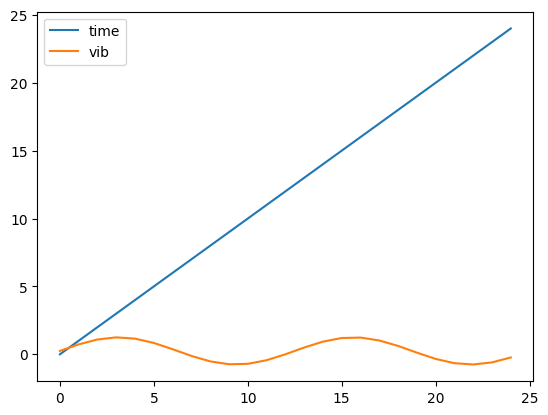

In [45]:
wavedf.plot()

Python class

In [46]:
import numpy as np
import pandas as pd

class pythonIQROutlier:
    """
    Outlier removal using Inter-quartile range.
    Will calculate q3 (75th) and q1 (25th) percentiles, and IQR = q3-q1.
    Then will remove data above 1.5*IQR+q3 and below q1 - 1.5*IQR.
    Factor 1.5 can be modified to go all the way to 3, depending on how much 
    data should be considered ourliers and removed

    """

    def __init__(self, df: pd.DataFrame, col_name: str, iqr_threshold:float = 1.5, lowerq:int = 25, upperq:int = 75):
        """
        Outlier removal using Inter-quartile range.
        Params:
            df = dataframe with data
            col_name = column in df, needs to be numeric
            iqr_threshold, lowerq, upperq = numeric constants for IQR filtering
        """
        self.df = df
        self.col_name = col_name
        self.iqr_threshold = iqr_threshold
        self.lowerq = lowerq
        self.upperq = upperq

    def calc_outliers(self):
        """
        Calculation of outliers based on the specified column.
        Returns:
            self
        """
        self.Q1, self.Q3 = np.percentile(self.df[self.col_name], [self.lowerq, self.upperq])
        self.IQR = self.Q3-self.Q1
        self.lower = max(0, self.Q1 - self.iqr_threshold*self.IQR)
        self.upper = self.Q3 + self.iqr_threshold*self.IQR
        return self

    def filter_data(self):
        """
        Removal of outliers in the whole dataframe

        Returns:
            dataframe
        """
        mask = (self.df[self.col_name] < self.upper) & (self.df[self.col_name] > self.lower)
        return self.df[mask]

Usage

Text(0.5, 1.0, 'Unfiltered sine wave (green) and filtered (black), with python-filter')

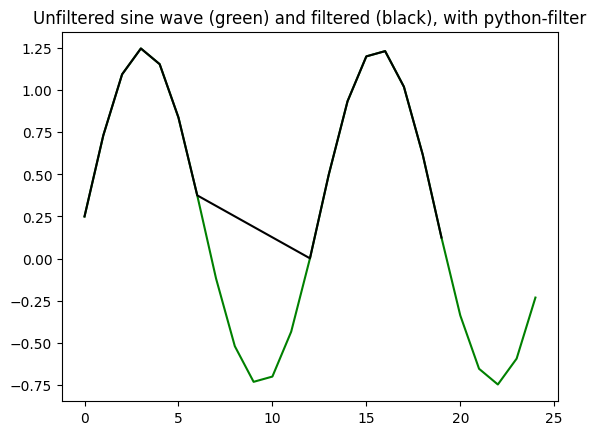

In [62]:
outlier_filt = pythonIQROutlier(wavedf, 'vib')
wavedf_filt = outlier_filt.calc_outliers().filter_data()


import matplotlib.pyplot as plt
plt.plot(wavedf['time'], wavedf['vib'], 'g')
plt.plot(wavedf_filt['time'], wavedf_filt['vib'], 'k')
plt.title('Unfiltered sine wave (green) and filtered (black), with python-filter')


Now with scikit custom Transformer

In [48]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin


class scikitIQROutlier(BaseEstimator, TransformerMixin):
    """
    Outlier removal using Inter-quartile range.
    Will calculate q3 (75th) and q1 (25th) percentiles, and IQR = q3-q1.
    Then will remove data above 1.5*IQR+q3 and below q1 - 1.5*IQR.
    Factor 1.5 can be modified to go all the way to 3, depending on how much 
    data should be considered ourliers and removed

    """

    def __init__(self, col_name:str, iqr_threshold:float = 1.5, lowerq:int = 25, upperq:int = 75):
        """
        Outlier removal using Inter-quartile range.
        Params:
            col_name = column in df, needs to be numeric
            iqr_threshold, lowerq, upperq = numeric constants for IQR filtering
        """
        self.col_name= col_name
        self.iqr_threshold = iqr_threshold
        self.lowerq = lowerq
        self.upperq = upperq

    def fit(self, X, y=None):
        """
        Calculation of outliers based on the specified column.
        Returns:
            self
        """
        self.Q1, self.Q3 = np.percentile(X[self.col_name], [self.lowerq, self.upperq])
        self.IQR = self.Q3-self.Q1
        self.lower = max(0, self.Q1 - self.iqr_threshold*self.IQR)
        self.upper = self.Q3 + self.iqr_threshold*self.IQR
        return self

    def transform(self, X, y=None):
        """
        Removal of outliers in the whole dataframe

        Returns:
            dataframe
        """
        mask = (X[self.col_name] < self.upper) & (X[self.col_name] > self.lower)
        return X[mask]

Usage

Text(0.5, 1.0, 'Unfiltered sine wave (green) and filtered (black), with scikit-filter')

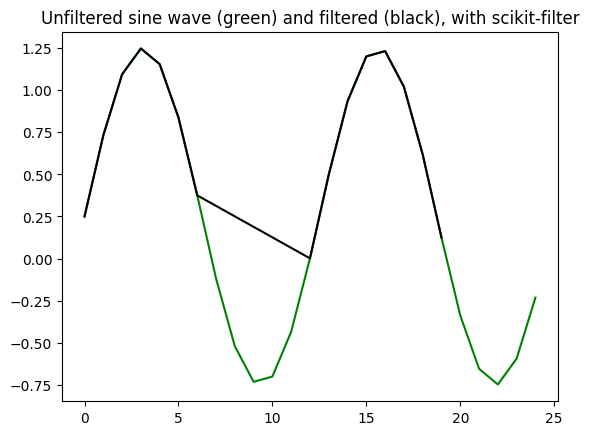

In [61]:
scikit_outlier_filt = scikitIQROutlier(col_name='vib')
wavedf_filt = scikit_outlier_filt.fit_transform(wavedf)

plt.plot(wavedf['time'], wavedf['vib'], 'g')
plt.plot(wavedf_filt['time'], wavedf_filt['vib'], 'k')
plt.title('Unfiltered sine wave (green) and filtered (black), with scikit-filter')


Text(0.5, 1.0, 'Unfiltered sine wave (green) and filtered, 25 median (black) and zero median (red), with scikit-filter')

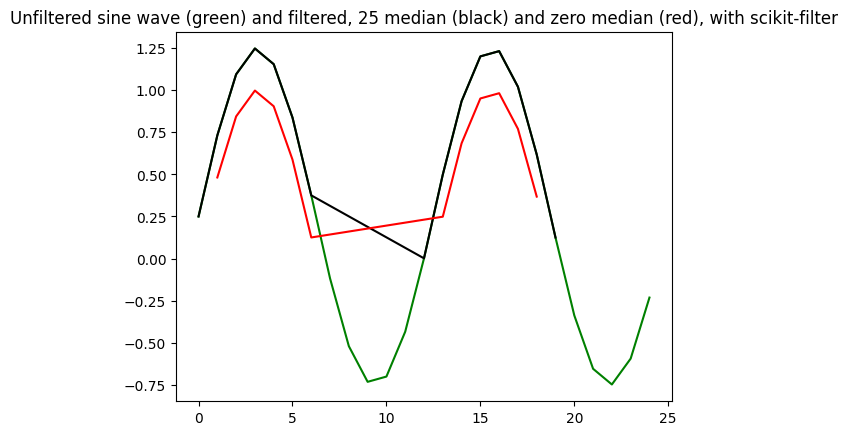

In [65]:
cycles = 2 # how many sine cycles
resolution = 25 # how many datapoints to generate

length = np.pi * 2 * cycles
my_wave = np.sin(np.arange(0, length, length / resolution))   # move the wave center down to zero
wavedfzero = pd.DataFrame(my_wave).reset_index()
wavedfzero.columns=['time', 'vib']

wavedf_filtzero = scikit_outlier_filt.transform(wavedfzero)

plt.plot(wavedf['time'], wavedf['vib'], 'g')
plt.plot(wavedf_filt['time'], wavedf_filt['vib'], 'k')
plt.plot(wavedf_filtzero['time'], wavedf_filtzero['vib'], 'r')
plt.title('Unfiltered sine wave (green) and filtered, 25 median (black) and zero median (red), with scikit-filter')


We can see that the red wave has been shifted down and chopped off closer to its bottom in comparison to the black curve. This means that the transformer was not refitted. It remembered setting from the black curve (median 25) and applied them to the red curve (median zero)